In [41]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce
#from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [42]:
data0=pd.read_csv("C:/Skola/Examensarbete/footballData.csv")

In [43]:
from sklearn.preprocessing import LabelEncoder

def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

#swedish_allsvenskan_data = data0[data0['league_name'] == 'Swedish Allsvenskan']
#data1=labelencoder(swedish_allsvenskan_data)
data1=labelencoder(data0)
m=len(data1)
M=list(range(m))
#random.seed(2021)
random.shuffle(M)

In [44]:

train=data1.iloc[M[0:(m//4)*3]]
test=data1.iloc[M[(m//4)*3:]]

sample = ['potential', 'league_rank', 'overall', 'age', 'team_position', 'international_reputation', 'pace', 'shooting', 'passing', 'dribbling']
target=['value_eur']
trainY=train[target]
trainX=train[sample]
#trainX=train
testY=test[target]
testX=test[sample]
#testX=test
df_columns = list(trainX.columns)

imputer = SimpleImputer(strategy='mean')

#x_train = trainX.values
#x_test = testX.values

x_train = imputer.fit_transform(trainX.values)
x_test = imputer.transform(testX.values)

In [45]:
pca = PCA(whiten=True)
pca.fit(x_train)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)


array([0.54347678, 0.69342694, 0.81545471, 0.8930848 , 0.9439191 ,
       0.98101928, 0.99536912, 0.99905353, 0.99985075, 1.        ])

In [46]:
pca = PCA(n_components=8,whiten=True)
pca = pca.fit(x_train)
dataPCA = pca.transform(x_train)

In [47]:
train_data = lgbm.Dataset(x_train, label=trainY.values.ravel())  
eval_data = lgbm.Dataset(x_test, label=testY.values.ravel(), reference=train_data) 

# Längden av x och y träningsdata
print('Train data x length: ', len(train_data.data))
print('Train data y length: ', len(train_data.label))

# Längden av x och y test data
print('Test data x length: ', len(eval_data.data))
print('Test data y length: ', len(eval_data.label))

Train data x length:  14208
Train data y length:  14208
Test data x length:  4736
Test data y length:  4736


In [48]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62,
    'verbosity':-1
    }


c:\Users\willi\anaconda3\envs\marketValuePrediction\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE:  630968.4569543885
R² score:  0.9849346542380542


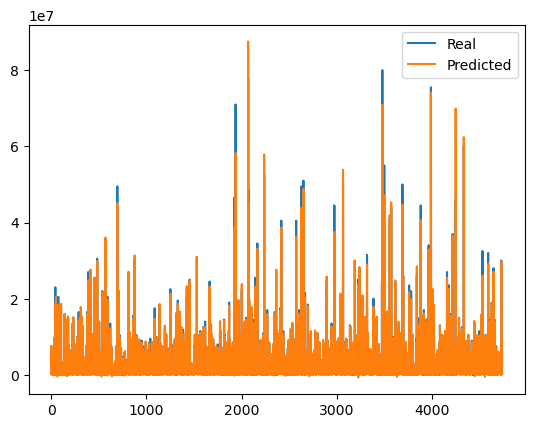

In [49]:
if os.path.exists('lightGBM_model.txt'):
    loaded_model = lgbm.Booster(model_file='lightGBM_model.txt')
    model = lgbm.train(params, train_data, valid_sets=[eval_data], num_boost_round=500, init_model=loaded_model)
else:
    model = lgbm.train(params, train_data, valid_sets=[eval_data], num_boost_round=500)
    
y_pred_loaded = model.predict(x_test, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(testY, y_pred_loaded))
# R² score
r2 = r2_score(testY, y_pred_loaded)

print('RMSE: ', rmse)
print('R² score: ', r2)

plt.plot(testY.values.ravel(), label='Real')
plt.plot(y_pred_loaded, label='Predicted')
plt.legend()
plt.show()

# Spara den nya modellen
model.save_model('lightGBM_model.txt')

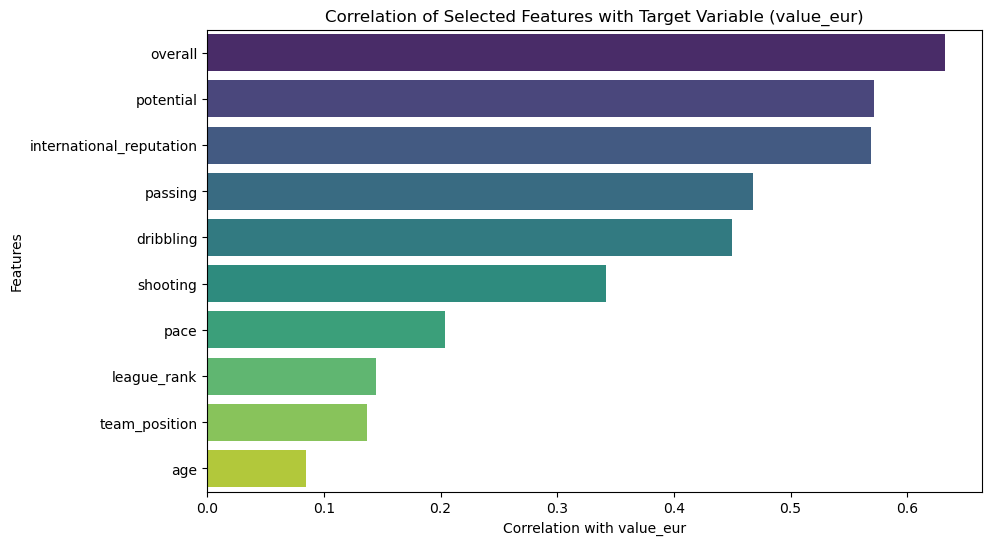

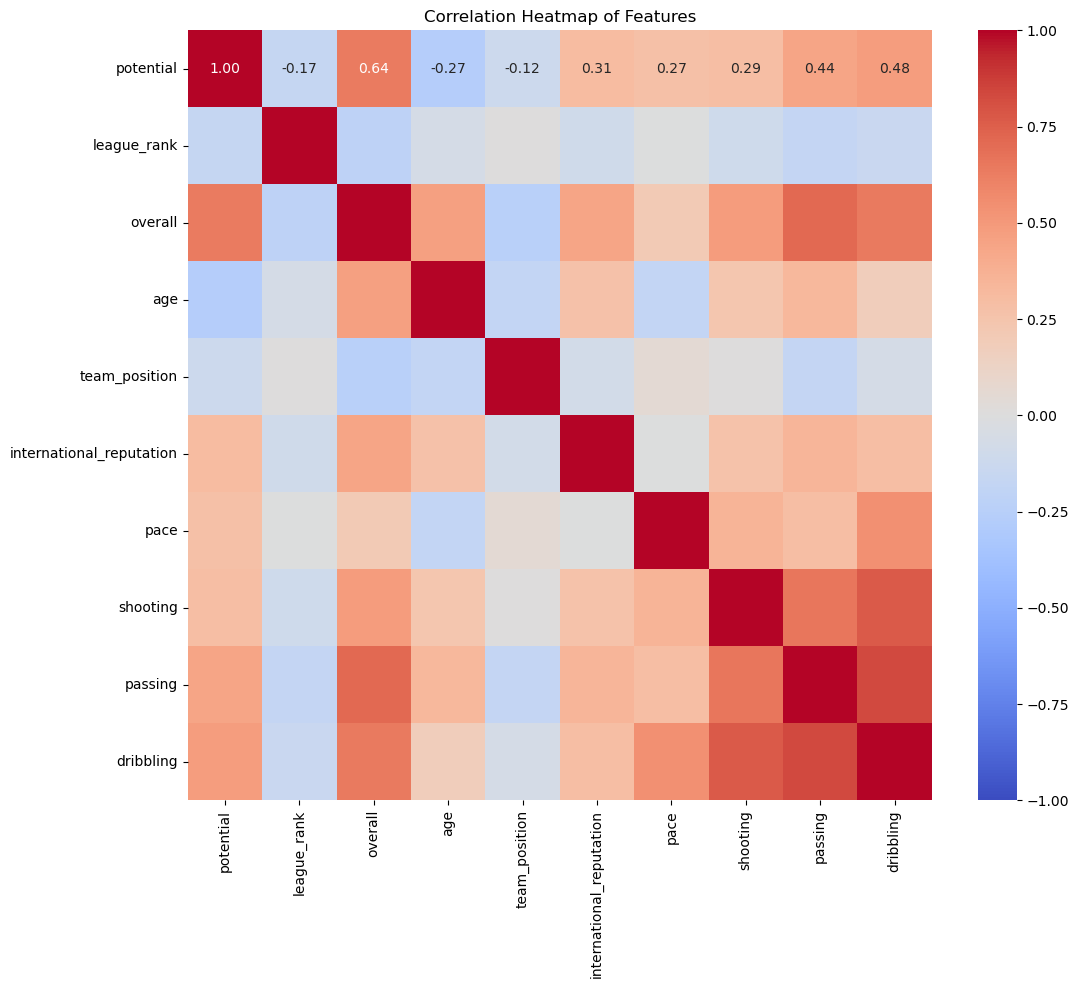

In [50]:
# Calculate the correlation between selected features and the target variable
feature_target_correlation = train[sample + ['value_eur']].corr()['value_eur'].drop('value_eur')

# Sort the correlations in descending order
sorted_correlation = feature_target_correlation.abs().sort_values(ascending=False)

# Plot the correlation of selected features with the target variable
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_correlation.values, y=sorted_correlation.index, palette='viridis')
plt.xlabel('Correlation with value_eur')
plt.ylabel('Features')
plt.title('Correlation of Selected Features with Target Variable (value_eur)')
plt.show()

# Calculate the correlation matrix
correlation_matrix = trainX.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Features')
plt.show()
